create sample:
- get NTL
- count points per city and filter > 100
- create intensity avg
- separate in groups of intensity (low, middle, high)
- create a sample of each group


https://sidra.ibge.gov.br/tabela/6579

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture 
import numpy as np
import math

In [3]:
nightlights = pd.read_csv('../model/nightlights_per_city.csv')

In [80]:
nightlights

,lat,long,radiance,geometry,index_right,CD_MUN,NM_MUN,SIGLA,AREA_KM2
0,5.270833,-60.212499,0.277005,POINT (-60.2124990417 5.270832775499997),150,1400704,Uiramutã,RR,8113.598
1,5.266666,-60.220832,0.278689,POINT (-60.2208323751 5.266666108799996),150,1400704,Uiramutã,RR,8113.598
2,5.266666,-60.216666,0.305580,POINT (-60.2166657084 5.266666108799996),150,1400704,Uiramutã,RR,8113.598
3,5.266666,-60.212499,0.278038,POINT (-60.2124990417 5.266666108799996),150,1400704,Uiramutã,RR,8113.598
4,5.266666,-60.208332,0.315737,POINT (-60.208332375 5.266666108799996),150,1400704,Uiramutã,RR,8113.598
...,...,...,...,...,...,...,...,...,...
40913427,-33.737501,-53.429166,0.374882,POINT (-53.4291656541 -33.7375008699),4714,4305439,Chuí,RS,202.387
40913428,-33.737501,-53.424999,0.399037,POINT (-53.4249989874 -33.7375008699),4714,4305439,Chuí,RS,202.387
40913429,-33.737501,-53.420832,0.416033,POINT (-53.4208323207 -33.7375008699),4714,4305439,Chuí,RS,202.387
40913430,-33.737501,-53.416666,0.410015,POINT (-53.416665654 -33.7375008699),4714,4305439,Chuí,RS,202.387


In [12]:
populacao = pd.read_csv('../input/populacao_estimada_2021.csv', sep=';')
populacao

,city_code,city_name,populacao
0,1100015,Alta Floresta D'Oeste (RO),22516
1,1100023,Ariquemes (RO),111148
2,1100031,Cabixi (RO),5067
3,1100049,Cacoal (RO),86416
4,1100056,Cerejeiras (RO),16088
...,...,...,...
5565,5222005,Vianópolis (GO),14088
5566,5222054,Vicentinópolis (GO),9002
5567,5222203,Vila Boa (GO),6451
5568,5222302,Vila Propício (GO),5941


In [ ]:
populacao[['city', 'state']] = populacao['city_name'].str.split('(', expand=True)
populacao['state'] = populacao['state'].str.replace(')', '')
del populacao['city_name']

(array([6.160e+02, 1.143e+03, 6.920e+02, 5.740e+02, 4.150e+02, 3.300e+02,
        2.640e+02, 1.950e+02, 1.590e+02, 1.240e+02, 1.190e+02, 7.000e+01,
        7.900e+01, 6.100e+01, 4.900e+01, 4.300e+01, 4.100e+01, 3.300e+01,
        3.300e+01, 2.600e+01, 3.000e+01, 2.100e+01, 2.000e+01, 1.700e+01,
        2.000e+01, 2.100e+01, 1.100e+01, 1.600e+01, 1.200e+01, 1.000e+01,
        5.000e+00, 1.800e+01, 1.000e+01, 6.000e+00, 1.000e+01, 8.000e+00,
        8.000e+00, 1.500e+01, 5.000e+00, 1.200e+01, 8.000e+00, 7.000e+00,
        6.000e+00, 3.000e+00, 4.000e+00, 3.000e+00, 6.000e+00, 7.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 6.000e+00,
        1.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 6.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        4.000e+00, 4.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 1.000e+0

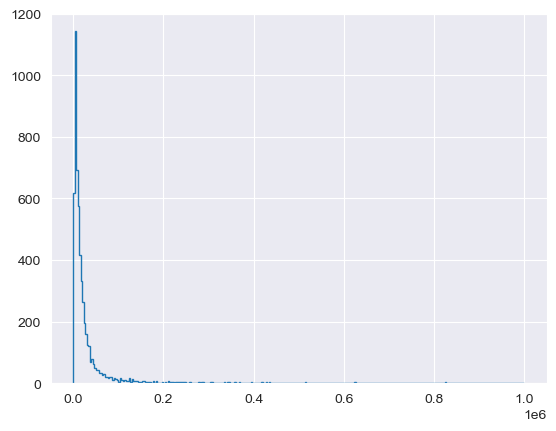

In [58]:
plt.hist(populacao['populacao'], bins=300, range=(0, 1e6),  histtype='step')


In [77]:
p50 = populacao['populacao'].quantile(0.5)
p10 = populacao['populacao'].quantile(0.1)
print(p50)
print(p10)

11732.0
3190.2999999999997


In [79]:
percentil = populacao[(populacao['populacao'] < p50) & (populacao['populacao'] > p10)]
percentil


,city_code,populacao,city,state
2,1100031,5067,Cabixi,RO
6,1100072,7052,Corumbiara,RO
18,1100262,3843,Rio Crespo,RO
20,1100296,5942,Santa Luzia D'Oeste,RO
28,1100502,8125,Novo Horizonte do Oeste,RO
...,...,...,...,...
5558,5221551,5447,Turvelândia,GO
5564,5221908,3848,Varjão,GO
5566,5222054,9002,Vicentinópolis,GO
5567,5222203,6451,Vila Boa,GO


In [87]:
filter_ntl = percentil.merge(nightlights, how='left', left_on=['city_code'], right_on=['CD_MUN'])
filter_ntl

,city_code,populacao,city,state,lat,long,radiance,geometry,index_right,CD_MUN,NM_MUN,SIGLA,AREA_KM2
0,1100031,5067,Cabixi,RO,-13.320834,-60.491666,0.229753,POINT (-60.4916657106 -13.320834039900006),2,1100031,Cabixi,RO,1314.352
1,1100031,5067,Cabixi,RO,-13.320834,-60.487499,0.224913,POINT (-60.4874990439 -13.320834039900006),2,1100031,Cabixi,RO,1314.352
2,1100031,5067,Cabixi,RO,-13.320834,-60.483332,0.211231,POINT (-60.4833323772 -13.320834039900006),2,1100031,Cabixi,RO,1314.352
3,1100031,5067,Cabixi,RO,-13.320834,-60.479166,0.258277,POINT (-60.4791657105 -13.320834039900006),2,1100031,Cabixi,RO,1314.352
4,1100031,5067,Cabixi,RO,-13.320834,-60.474999,0.263317,POINT (-60.4749990438 -13.320834039900006),2,1100031,Cabixi,RO,1314.352
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8367965,5222302,5941,Vila Propício,GO,-15.562501,-49.020832,0.267568,POINT (-49.020832285500006 -15.562500724499998),5570,5222302,Vila Propício,GO,2181.593
8367966,5222302,5941,Vila Propício,GO,-15.562501,-49.016666,0.251217,POINT (-49.016665618800005 -15.562500724499998),5570,5222302,Vila Propício,GO,2181.593
8367967,5222302,5941,Vila Propício,GO,-15.562501,-49.012499,0.260357,POINT (-49.0124989521 -15.562500724499998),5570,5222302,Vila Propício,GO,2181.593
8367968,5222302,5941,Vila Propício,GO,-15.566667,-49.020832,0.277616,POINT (-49.020832285500006 -15.5666673912),5570,5222302,Vila Propício,GO,2181.593


In [88]:
ntl_grouped = filter_ntl.groupby(['city_code', 'city', 'state']) \
       .agg(count=('radiance', 'size'), avg=('radiance', 'mean')) \
       .reset_index()
ntl_grouped = ntl_grouped[ntl_grouped['count'] > 100]
ntl_grouped

,city_code,city,state,count,avg
0,1100031,Cabixi,RO,6315,0.287673
1,1100072,Corumbiara,RO,14685,0.248848
2,1100262,Rio Crespo,RO,8118,0.272294
3,1100296,Santa Luzia D'Oeste,RO,5730,0.276204
4,1100502,Novo Horizonte do Oeste,RO,4013,0.305925
...,...,...,...,...,...
2223,5221551,Turvelândia,GO,4592,0.373203
2224,5221908,Varjão,GO,2529,0.318635
2225,5222054,Vicentinópolis,GO,3590,0.400572
2226,5222203,Vila Boa,GO,5090,0.270832


In [109]:
ntl_grouped.groupby('state').count()

,city_code,city,count,avg
state,,,,
AC,5,5,5,5
AL,38,38,38,38
AM,3,3,3,3
AP,7,7,7,7
BA,112,112,112,112
CE,29,29,29,29
ES,16,16,16,16
GO,116,116,116,116
MA,56,56,56,56


In [111]:
ufs = ntl_grouped['state'].unique()
ufs

array(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO'], dtype=object)

In [92]:
def createClusters(data):
    mixture = GaussianMixture(n_components=3).fit(np.array(data['avg']).reshape(-1, 1))
    means_hat = np.sort(mixture.means_.flatten())
    # weights_hat = mixture.weights_.flatten()
    # sds_hat = np.sqrt(mixture.covariances_).flatten()
    # print(mixture.converged_)
    # print(means_hat)
    return means_hat
    # print(sds_hat)
    # print(weights_hat)


In [93]:
def checkType(avg, clusters):
    if avg < clusters[0]:
        return '0'
    elif avg < clusters[1]:
        return '1'
    else:
        return '2'

In [123]:
import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame()
for uf in ufs:
    # print(uf)
    citiesByUF = ntl_grouped[ntl_grouped['state'] == uf]
    total = len(citiesByUF)
    if total <= 3:
        df = df.append(citiesByUF)
    else:
        # percentil = total * 0.10
        # nByGroup = math.ceil(percentil / 3)
        nByGroup = 2

        clusters = createClusters(citiesByUF)
        citiesByUF['type'] = citiesByUF.apply(lambda x: checkType(x.avg, clusters), axis=1)
        sample = citiesByUF.groupby('type').sample(n=nByGroup, replace=True)
        df = df.append(sample)
    # break


In [124]:
df1 = df.drop_duplicates(keep='first')
df1

,city_code,city,state,count,avg,type
11,1101450,Parecis,RO,12173,0.227045,0
6,1101005,Governador Jorge Teixeira,RO,24072,0.221167,0
12,1101484,São Felipe D'Oeste,RO,2586,0.294191,1
3,1100296,Santa Luzia D'Oeste,RO,5730,0.276204,1
9,1101302,Mirante da Serra,RO,5689,0.307949,2
...,...,...,...,...,...,...
2113,5200175,Água Fria de Goiás,GO,9792,0.345685,0
2161,5209150,Gouvelândia,GO,4080,0.434193,1
2189,5215405,Ouro Verde de Goiás,GO,1011,0.489992,1
2112,5200050,Abadia de Goiás,GO,705,2.269023,2


In [127]:
df1.groupby('state').count()

,city_code,city,count,avg,type
state,,,,,
AC,3,3,3,3,3
AL,6,6,6,6,6
AM,3,3,3,3,0
AP,5,5,5,5,5
BA,6,6,6,6,6
CE,6,6,6,6,6
ES,6,6,6,6,6
GO,6,6,6,6,6
MA,6,6,6,6,6


In [126]:
df1.groupby('type').count()

,city_code,city,state,count,avg
type,,,,,
0,44,44,44,44,44
1,47,47,47,47,47
2,46,46,46,46,46


In [128]:
df1.to_csv('../model/small_cities_sample.csv', index=False)

In [129]:
filter_ntl = df1.merge(nightlights, how='left', left_on=['city_code'], right_on=['CD_MUN'])
filter_ntl

,city_code,city,state,count,avg,type,lat,long,radiance,geometry,index_right,CD_MUN,NM_MUN,SIGLA,AREA_KM2
0,1101450,Parecis,RO,12173,0.227045,0,-12.004167,-61.333332,0.226823,POINT (-61.333332384 -12.004167362700002),41,1101450,Parecis,RO,2548.683
1,1101450,Parecis,RO,12173,0.227045,0,-12.004167,-61.329166,0.252866,POINT (-61.3291657173 -12.004167362700002),41,1101450,Parecis,RO,2548.683
2,1101450,Parecis,RO,12173,0.227045,0,-12.004167,-61.324999,0.221371,POINT (-61.3249990506 -12.004167362700002),41,1101450,Parecis,RO,2548.683
3,1101450,Parecis,RO,12173,0.227045,0,-12.004167,-61.320832,0.203252,POINT (-61.3208323839 -12.004167362700002),41,1101450,Parecis,RO,2548.683
4,1101450,Parecis,RO,12173,0.227045,0,-12.004167,-61.316666,0.213139,POINT (-61.3166657172 -12.004167362700002),41,1101450,Parecis,RO,2548.683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212028,5204250,Cachoeira Dourada,GO,2600,0.853807,2,-18.612501,-49.741666,0.273667,POINT (-49.74166562459999 -18.612500748900004),5369,5204250,Cachoeira Dourada,GO,528.281
1212029,5204250,Cachoeira Dourada,GO,2600,0.853807,2,-18.612501,-49.737499,0.284952,POINT (-49.73749895789999 -18.612500748900004),5369,5204250,Cachoeira Dourada,GO,528.281
1212030,5204250,Cachoeira Dourada,GO,2600,0.853807,2,-18.612501,-49.733332,0.268688,POINT (-49.73333229119999 -18.612500748900004),5369,5204250,Cachoeira Dourada,GO,528.281
1212031,5204250,Cachoeira Dourada,GO,2600,0.853807,2,-18.612501,-49.729166,0.248612,POINT (-49.729165624499984 -18.612500748900004),5369,5204250,Cachoeira Dourada,GO,528.281


In [130]:
filter_ntl.to_csv('../model/filtered_nighttime_lights.csv', index=False)

VISUALIZATION

In [131]:
gdf = gpd.read_file('../input/shapes/BR_Municipios_2021/BR_Municipios_2021.shp')

In [137]:
cities = filter_ntl['city_code'].unique()
# len(cities)
# print(gdf)
# print(cities)

       CD_MUN                 NM_MUN SIGLA  AREA_KM2  \
0     1100015  Alta Floresta D'Oeste    RO  7067.127   
1     1100023              Ariquemes    RO  4426.571   
2     1100031                 Cabixi    RO  1314.352   
3     1100049                 Cacoal    RO  3793.000   
4     1100056             Cerejeiras    RO  2783.300   
...       ...                    ...   ...       ...   
5567  5222005             Vianópolis    GO   954.115   
5568  5222054         Vicentinópolis    GO   733.794   
5569  5222203               Vila Boa    GO  1052.593   
5570  5222302          Vila Propício    GO  2181.593   
5571  5300108               Brasília    DF  5760.784   

                                               geometry  sample  
0     POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...       0  
1     POLYGON ((-62.53648 -9.73222, -62.52765 -9.736...       0  
2     POLYGON ((-60.37119 -13.36655, -60.37134 -13.3...       0  
3     POLYGON ((-61.00080 -11.29737, -61.00103 -11.3...       0

In [153]:
gdf['sample'] = 0
gdf['CD_MUN'].astype(int)

# create a dictionary that maps each city code to a color
colors = {}

for index, row in gdf.iterrows():
    # compare the age value in the current row with the array elements
    colors[row['CD_MUN']] = '#222220'
    for city in cities:
        # print(row['CD_MUN'])
        # print('city ', type(str(city)))
        # print('row ', type(row['CD_MUN']))
        if row['CD_MUN'] == str(city):
            gdf.at[index, 'sample'] = 1
            # print('CHEGOU AQUI')
            colors[str(city)] = '#64AAE9'
            break

In [154]:
colors

{'1100015': '#222220',
 '1100023': '#222220',
 '1100031': '#222220',
 '1100049': '#222220',
 '1100056': '#222220',
 '1100064': '#222220',
 '1100072': '#222220',
 '1100080': '#222220',
 '1100098': '#222220',
 '1100106': '#222220',
 '1100114': '#222220',
 '1100122': '#222220',
 '1100130': '#222220',
 '1100148': '#222220',
 '1100155': '#222220',
 '1100189': '#222220',
 '1100205': '#222220',
 '1100254': '#222220',
 '1100262': '#222220',
 '1100288': '#222220',
 '1100296': '#64AAE9',
 '1100304': '#222220',
 '1100320': '#222220',
 '1100338': '#222220',
 '1100346': '#222220',
 '1100379': '#222220',
 '1100403': '#222220',
 '1100452': '#222220',
 '1100502': '#222220',
 '1100601': '#222220',
 '1100700': '#222220',
 '1100809': '#222220',
 '1100908': '#222220',
 '1100924': '#222220',
 '1100940': '#222220',
 '1101005': '#64AAE9',
 '1101104': '#222220',
 '1101203': '#222220',
 '1101302': '#64AAE9',
 '1101401': '#222220',
 '1101435': '#222220',
 '1101450': '#64AAE9',
 '1101468': '#222220',
 '1101476':

(-76.24759047174989,
 -26.590499411249958,
 -35.702328947549944,
 7.222992030550017)

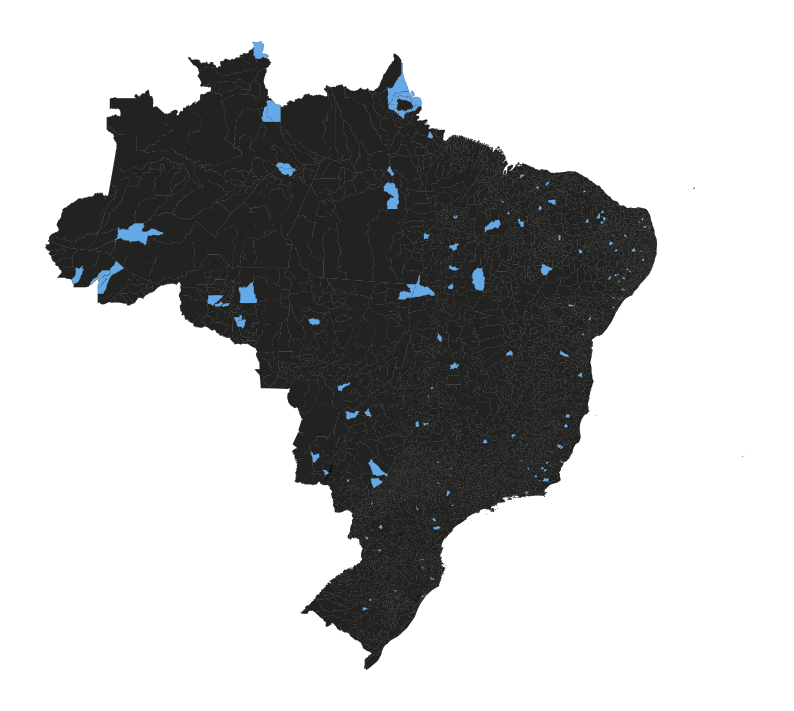

In [155]:
fig, ax = plt.subplots(figsize=(10,10))
gdf_plot = gdf.plot(linewidth=0.1, edgecolor='black', legend=False, facecolor=[colors[code] for code in gdf['CD_MUN']], ax=ax)
ax.axis('off')